In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
START = '2018Q1'
END = '2023Q4'

In [3]:
project_names = pd.read_json("data/gitcoin-project-names.json").set_index('slug')['name'].to_dict()

In [4]:
impact = pd.read_csv("data/csv/gitcoin_contributor_impact_by_quarter.csv", index_col=0)
impact = impact[(impact['quarter'] >= START) & (impact['quarter'] <= END)]
impact = impact[impact['project_slug'] != 'gitcoin']
impact.rename(columns={'day': 'days_contributed'}, inplace=True)

top50_oss_slugs = (    
    impact
    .groupby('project_slug')
    ['from_name']
    .nunique()
    .sort_values()
    .tail(50)
    .index
    .to_list()
)
impact = impact[impact['project_slug'].isin(top50_oss_slugs)]

impact.head(1)

,project_slug,from_name,quarter,days_contributed
0,4everland,2062686364,2021Q3,1


In [5]:
grants = pd.read_csv("data/csv/gitcoin_top_oss_grantees.csv", index_col=0)
grants['quarter'] = pd.PeriodIndex(grants.round_date, freq='Q')
grants['quarter'] = grants['quarter'].apply(str)

grants = grants[['oso_slug', 'round_id', 'round_name', 'quarter', 'round_date', 'total_usd']]
grants = grants[grants['oso_slug'].isin(top50_oss_slugs)]

def name_round(rid, rname):
    if '0x' in rid:
        return rname
    else:
        return f"GR{rid}"
grants['round'] = grants.apply(lambda x: name_round(x['round_id'], x['round_name']), axis=1)

# manual updates to clean a few rounds that are on the edge of a quarter
grants.loc[grants['round'] == 'GR2', 'quarter'] = '2019Q2'
grants.loc[grants['round'] == 'GR4', 'quarter'] = '2019Q4'

# rename allo grants
grants.loc[grants['quarter'] == '2023Q1', 'round'] = 'Alpha'
grants.loc[grants['quarter'] == '2023Q2', 'round'] = 'Beta'
grants.loc[grants['quarter'] == '2023Q3', 'round'] = 'GG18'
grants.loc[grants['quarter'] == '2023Q4', 'round'] = 'GG19'

grants.head(1)

,oso_slug,round_id,round_name,quarter,round_date,total_usd,round
18,l2beat,0x222ea76664ed77d18d4416d2b2e77937b76f0a35,Ethereum Infrastructure,2023Q3,2023-08-15 08:00:00,30127.21813,GG18


In [6]:
grant_stats = grants.groupby(['quarter','round'])['total_usd'].sum().apply(int)
grant_stats.sum()

8489524

In [7]:
impact

,project_slug,from_name,quarter,days_contributed
0,4everland,2062686364,2021Q3,1
1,4everland,4everlandorg,2023Q1,1
2,4everland,4everlandorg,2023Q3,1
3,4everland,Alexandas,2022Q1,3
4,4everland,Alexandas,2022Q2,1
...,...,...,...,...
38458,zeropoolnetwork,voidxnull,2023Q1,23
38459,zeropoolnetwork,voidxnull,2023Q2,24
38460,zeropoolnetwork,voidxnull,2023Q3,9
38461,zeropoolnetwork,voidxnull,2023Q4,6


In [8]:
projects_first_rounds = (
    grants
    .groupby(['oso_slug'])
    ['quarter']
    .min()
    .reset_index()
    .groupby('quarter')
    ['oso_slug']
    .agg(lambda x: sorted(x))
)
ordered_projects_list = [p for lst in projects_first_rounds for p in lst]
projects_first_rounds.head(2)

quarter
2019Q1    [ethers-io, lighthouse-sigp, prysmaticlabs]
2019Q3                      [dappnode, nethermindeth]
Name: oso_slug, dtype: object

In [9]:
quarters = sorted(impact['quarter'].unique())
quarter_mapping = dict(zip(quarters, range(len(quarters))))

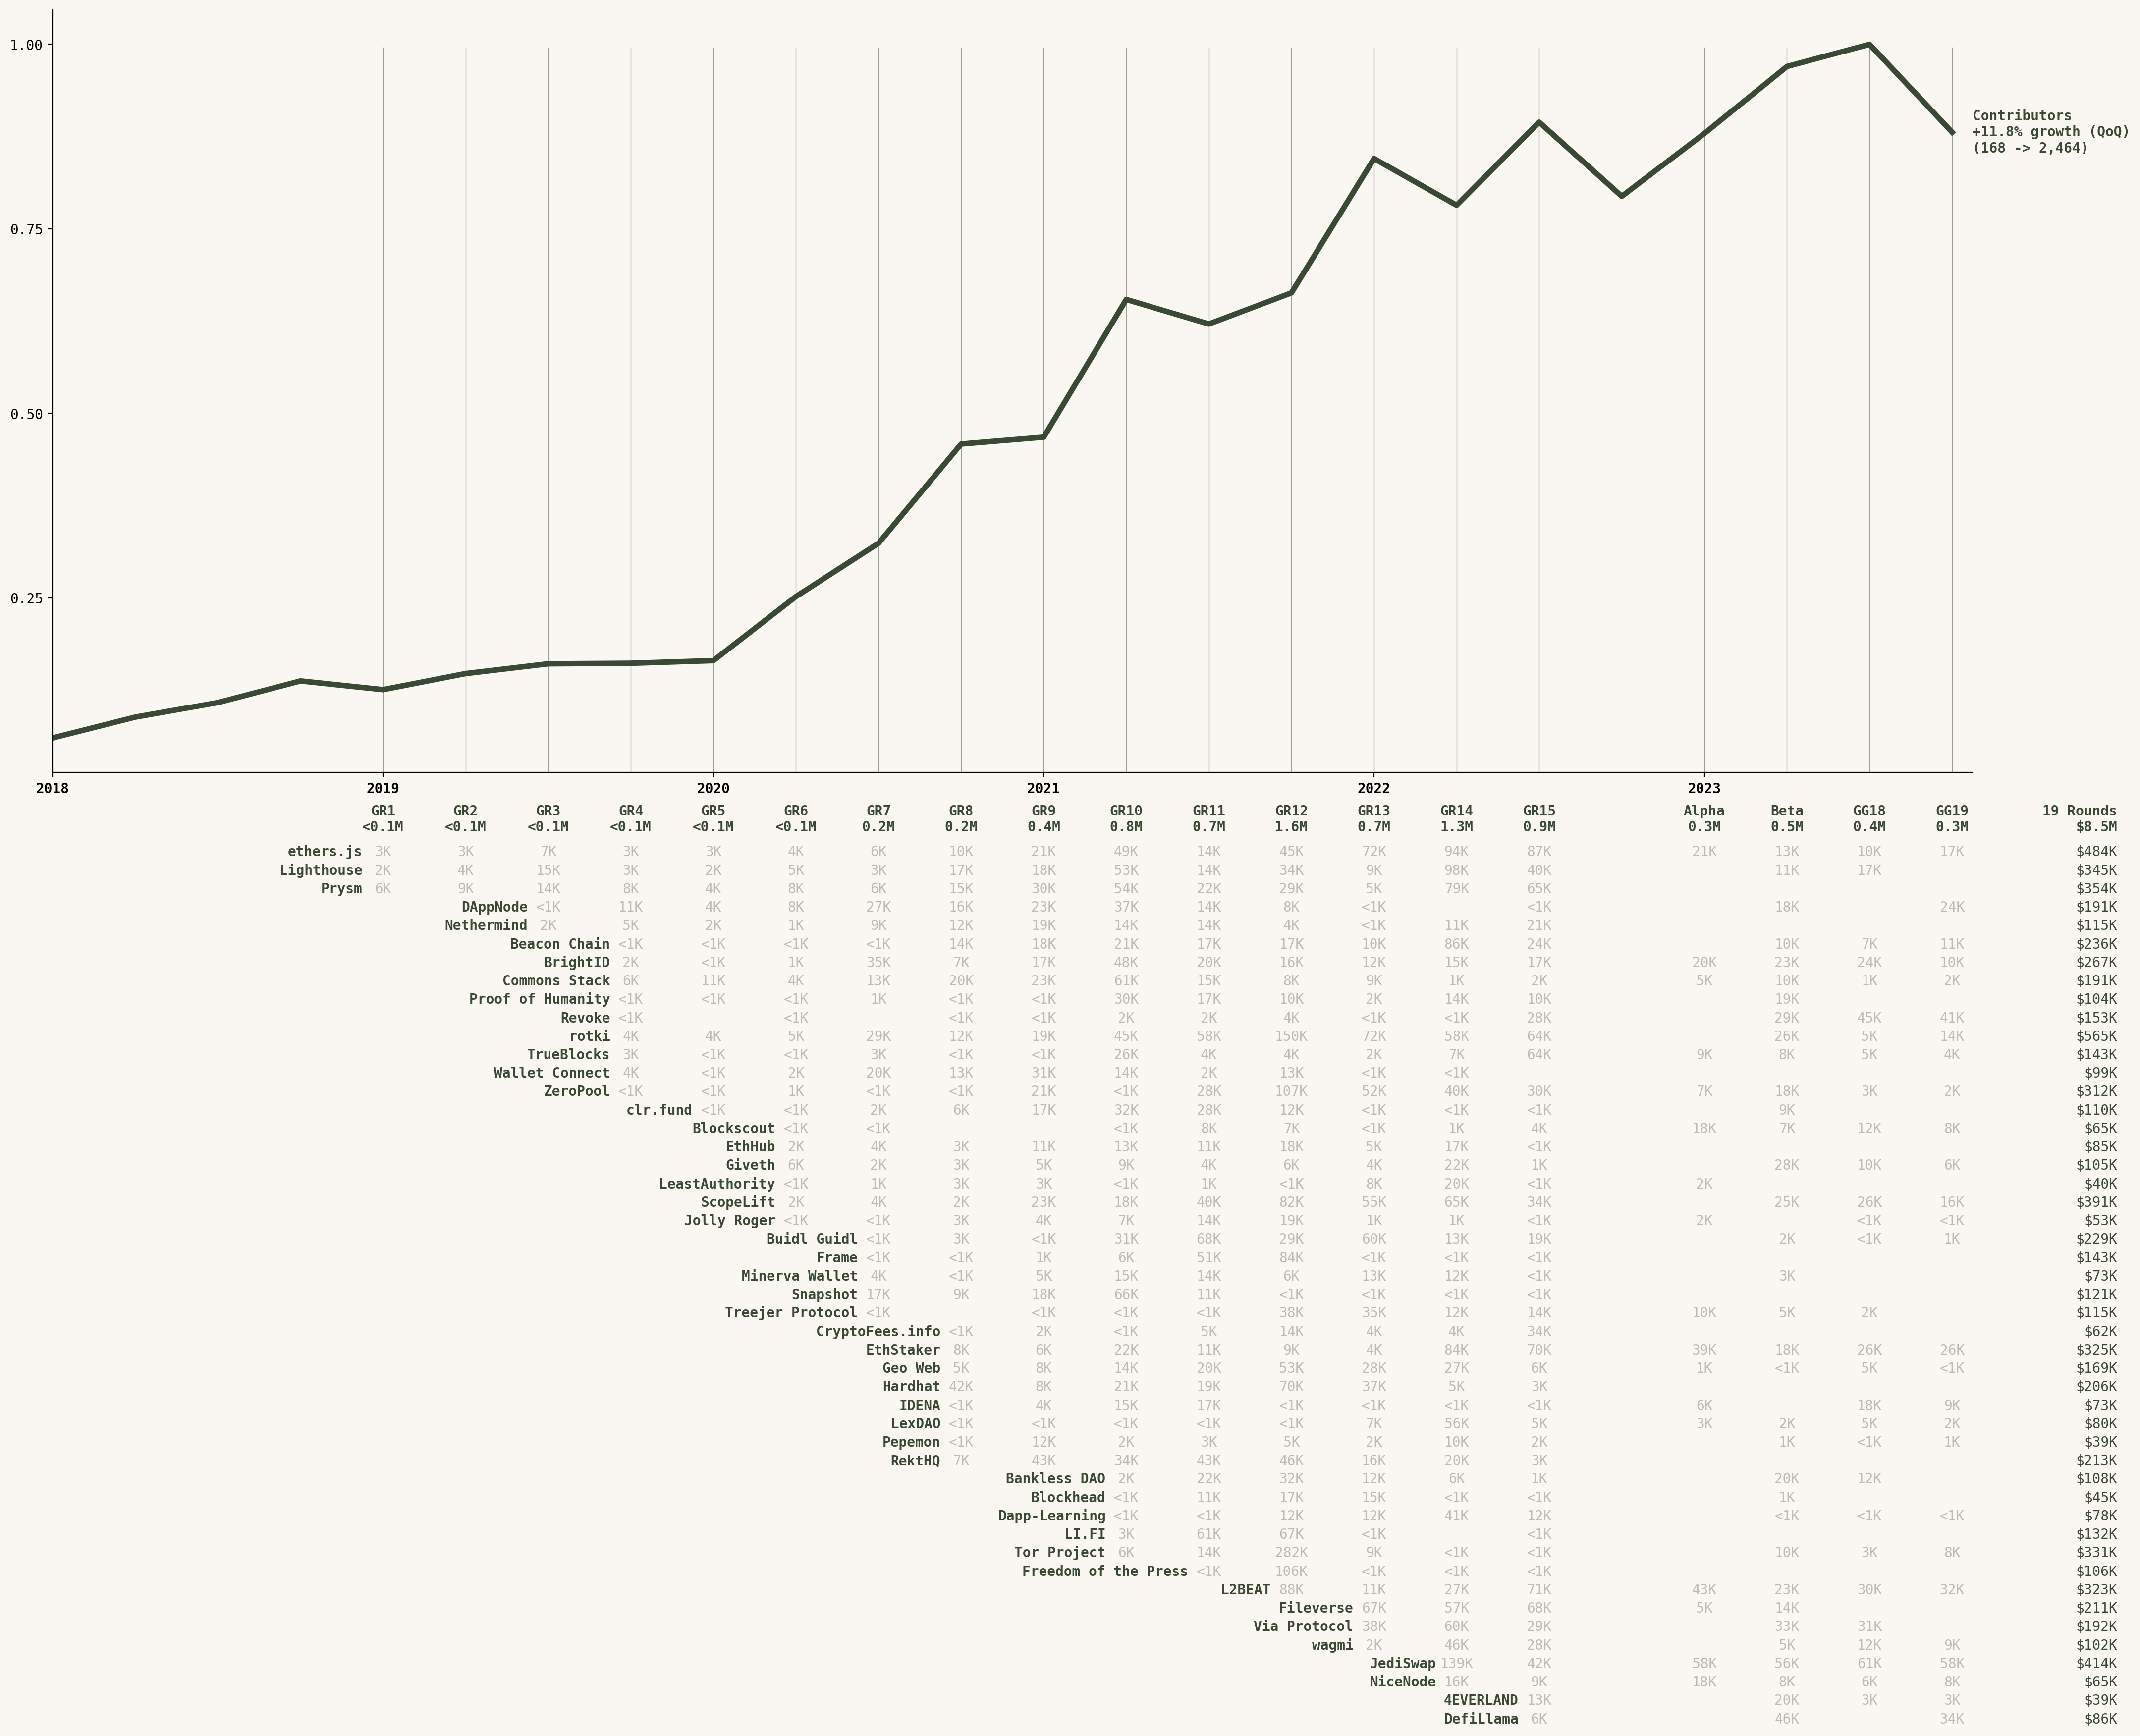

In [41]:
# styling constants
matplotlib.rcParams.update({'font.family': 'monospace'})

PURPLE = '#6935FF'
GREEN = '#3A4934'
WHITE = '#FAF7F3'
SMALL = 10
YSUB = -.1
YSUB_OFFSET = .025

# define the impact vector
vector = (
    impact
    .groupby('quarter')
    ['from_name']
    .nunique()
    .rename('OSS Contributors')
)
peak_impact = vector.max()
scaled_vector = vector/peak_impact
cagr = round(((vector[-1] / vector[0]) ** (1/len(vector)) - 1)*100,1) 

# plot the impact metric
fig, ax = plt.subplots(figsize=(25,10), dpi=200, facecolor=WHITE)
scaled_vector.plot(kind='line', lw=4, ax=ax, color=GREEN)

# add vertical lines signifying funding events     
amt_fmt = lambda a: "<0.1M" if a < 100_000 else f"{a/1_000_000:.1f}M"
amt_fmt_k = lambda a: "<1K" if a < 1000 else f"{a/1000:.0f}K"
for i, ((quarter, round_name), amount) in enumerate(grant_stats.items()):
    x = quarter_mapping.get(quarter)
    if not x:
        continue
    ax.axvline(x=x, ymin=0, ymax=.95, color=GREEN, lw=.5, alpha=.5)
    amt = amt_fmt(amount)
    label = f"{round_name}\n{amt}"
    ax.text(s=label, 
            x=x, 
            y=YSUB/2, 
            ha='center', 
            va='center', 
            fontsize=SMALL, 
            color=GREEN, 
            weight='bold')
    
    # add project first funding dates
    first_round_projects = projects_first_rounds.get(quarter)
    for y, project_slug in enumerate(ordered_projects_list):
        filtered_grants = grants[grants['quarter'] == quarter]
        included_projects = filtered_grants['oso_slug'].to_list()
        if project_slug not in included_projects:
            continue

        if first_round_projects and project_slug in first_round_projects:
            ax.text(s=project_names[project_slug], 
                    x=x-.25, 
                    y=YSUB-(y*YSUB_OFFSET), 
                    color=GREEN, 
                    weight='bold', 
                    ha='right')
        
        result = filtered_grants[filtered_grants['oso_slug'] == project_slug]['total_usd'].sum()
        label = amt_fmt_k(result)
        ax.text(s=label, 
                x=x, 
                y=YSUB-(y*YSUB_OFFSET), 
                color='grey',
                alpha=.5, 
                ha='center')


# add quarter and year tick labels
interval = 4
quarters_list = list(quarter_mapping.keys())    
start_q, end_q = quarter_mapping.get(START), quarter_mapping.get(END)
ax.set_xlim(start_q, end_q+.25)    
xs = list(range(0, len(quarters_list), interval))    
ax.set_xticks(xs) 
ax.set_xticklabels([str(x) for x in range(2018,2024)], weight='bold')

# add summary metrics
ax.text(s=f"19 Rounds\n${amt_fmt(grant_stats.sum())}", 
        x=end_q+2, 
        y=YSUB/2, 
        weight='bold', 
        ha='right', 
        va='center', 
        color=GREEN)
ax.text(s="\n".join([
            "Contributors", 
            f"+{cagr}% growth (QoQ)",
            f"({vector[0]:,.0f} -> {vector[-1]:,.0f})"]), 
        x=end_q+.25, 
        y=scaled_vector[-1], 
        weight='bold', 
        ha='left', 
        va='center', 
        color=GREEN)

for y, project_slug in enumerate(ordered_projects_list):
    funding = grants[grants['oso_slug'] == project_slug]['total_usd'].sum()
    ax.text(s=f"${amt_fmt_k(funding)}", x=end_q+2, y=YSUB-(y*YSUB_OFFSET), ha='right', color=GREEN)

    
# styling tweaks    
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_yticks([.25,.5,.75,1])
ax.set_facecolor(WHITE)
sns.despine()    
#fig.tight_layout()

# old version

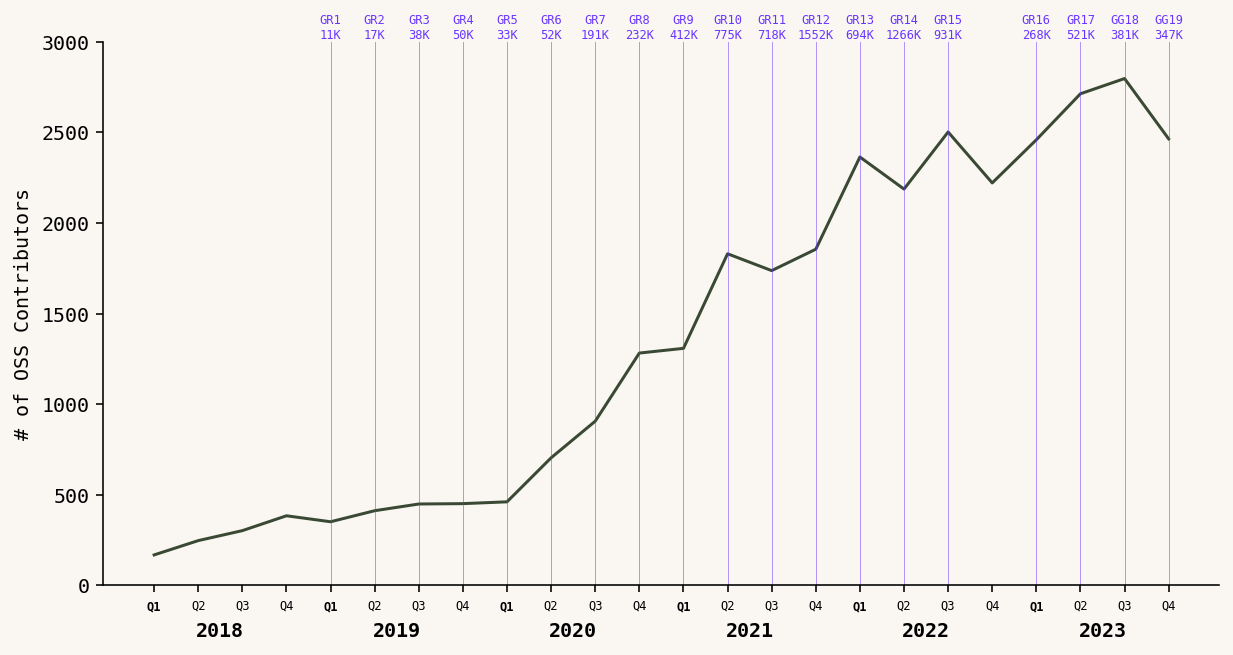

In [11]:
fig, ax = plt.subplots(figsize=(10,5), dpi=144, facecolor=WHITE)
(
    impact
    .groupby('quarter')
    ['from_name']
    .nunique()
    .apply(int)
    .plot(
        kind='line', 
        ax=ax, 
        color=GREEN
    )
)


quarters_list = list(quarter_mapping.keys())    
grant_streams = grants.groupby('quarter')['total_usd'].sum()
grant_streams = grant_streams[grant_streams>0]
for i, (quarter, amount) in enumerate(grant_streams.items()):
    q = quarter_mapping.get(quarter)
    lbl = f"GR{i+1}" if i < 17 else f"GG{i+1}"
    lbl += f"\n{amount/1000:.0f}K"
    ax.text(s=lbl, x=q, y=3000, ha='center', va='bottom', fontsize=6, color=PURPLE)
    ax.axvline(x=q, color=PURPLE, lw=.5, alpha=.5)
    
# add quarter and year tags
start_q, end_q = quarter_mapping.get("2017Q1"), quarter_mapping.get("2023Q4")
ax.set_xlim(start_q, )    
xs = list(range(0, len(quarters_list), 1))    
ax.set_xticks(xs) 
ax.set_xticklabels([quarters_list[x][-2:] for x in xs], fontsize=6)
[ax.get_xticklabels()[i].set_weight("bold") for i in range(len(xs)) if not(i % 4)]
for i,x in enumerate(quarters_list[::4]):
    year = x[:4]
    ax.text(s=year, x=(i*4+1.5), y=-200, ha="center", va='top', weight='bold')

ax.set_ylim(0,3000)
ax.set_xlabel("")
ax.set_ylabel("# of OSS Contributors")
ax.set_facecolor(WHITE)
sns.despine()